## Importing Libraries

In [1]:
import locale
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from typing import Optional, List, Tuple
import pacmap
import plotly.express as px

# PyTorch
import torch

# Hugging Face
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, TextStreamer
from sentence_transformers import SentenceTransformer
import datasets

# Langchain
from langchain.docstore.document import Document as LangchainDocument
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy
#from langchain_community.document_loaders.csv_loader import CSVLoader

In [2]:
# Set locale to UTF-8
locale.getpreferredencoding = lambda: 'UTF-8'
# Set pandas display options
pd.set_option("display.max_colwidth", None)

## Device

In [3]:
# Device setup
device = (
    "cuda:0" if torch.cuda.is_available() else # Nvidia GPU
    "mps" if torch.backends.mps.is_available() else # Apple Silicon GPU
    "cpu"
)
print(f"Device = {device}")

Device = cuda:0


In [4]:
# Flash Attention Implementation
if device == "cuda:0":
    if torch.cuda.get_device_capability()[0] >= 8: # Ampere, Ada, or Hopper GPUs
        attn_implementation = "flash_attention_2"
        torch_dtype = torch.bfloat16
    else:
        attn_implementation = "eager"
        torch_dtype = torch.float16
else:
    attn_implementation = "eager"
    torch_dtype = torch.float32
print(f"Attention Implementation = {attn_implementation}")

Attention Implementation = flash_attention_2


## Hyperparameters

In [5]:
################################################################################
# Tokenizer parameters
################################################################################
max_length=8192
padding="do_not_pad"  # "max_length", "longest", "do_not_pad"
truncation=True

################################################################################
# Generation parameters
################################################################################
num_return_sequences=1
max_new_tokens=1024
do_sample=True  # True for sampling, False for greedy decoding
temperature=0.6
top_p=0.9
repetition_penalty=1.1

################################################################################
# bitsandbytes parameters
################################################################################
load_in_4bit=True
bnb_4bit_compute_dtype=torch_dtype
bnb_4bit_quant_type="nf4"  # "nf4", #fp4"
bnb_4bit_use_double_quant=True

################################################################################
# Retriever parameters
################################################################################
top_k=5
chunk_size=512  # The maximum number of characters in a chunk
chunk_overlap=10  # The number of characters to overlap between chunks
add_start_index=True  # If `True`, includes chunk's start index in metadata
strip_whitespace=True  # If `True`, strips whitespace from the start and end of every document
markdown_separators = [
    "\n#{1,6} ",
    "```\n",
    "\n\\*\\*\\*+\n",
    "\n---+\n",
    "\n___+\n",
    "\n\n",
    "\n",
    " ",
    "",
]

## Model

In [6]:
# Model ID
model_id = "PathFinderKR/Waktaverse-Llama-2-KO-7B-Instruct"

In [7]:
# Embedding model ID
embedding_model_id = "thenlper/gte-small"

In [8]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_id)
embedding_tokenizer = AutoTokenizer.from_pretrained(embedding_model_id)
streamer = TextStreamer(tokenizer)

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [9]:
# Quantization
quantization_config = BitsAndBytesConfig(
    load_in_4bit=load_in_4bit,
    bnb_4bit_compute_dtype=bnb_4bit_compute_dtype,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_use_double_quant=bnb_4bit_use_double_quant
)

In [12]:
# Load model
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map=device,
    attn_implementation=attn_implementation,
    torch_dtype=torch_dtype,
    quantization_config=quantization_config
)
embedding_model = HuggingFaceEmbeddings(
    model_name=embedding_model_id,
    multi_process=True,
    model_kwargs={"device": device},
    encode_kwargs={"normalize_embeddings": True},  # Set `True` for cosine similarity
)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

/home/pathfinder/anaconda3/envs/torch-env/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


## Documents

In [13]:
# Load documents
ds = datasets.load_dataset("m-ric/huggingface_doc", split="train")
knowledge_base = [
    LangchainDocument(page_content=doc["text"], metadata={"source": doc["source"]}) for doc in tqdm(ds)
]

  0%|          | 0/2647 [00:00<?, ?it/s]

In [14]:
# Split documents
splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
    tokenizer=embedding_tokenizer,
    chunk_size=chunk_size,
    chunk_overlap=chunk_overlap,
    add_start_index=add_start_index,
    strip_whitespace=strip_whitespace,
    separators=markdown_separators
)
documents = splitter.split_documents(knowledge_base)
# Remove duplicates
documents = list({doc.page_content: doc for doc in documents}.values())

  0%|          | 0/17770 [00:00<?, ?it/s]

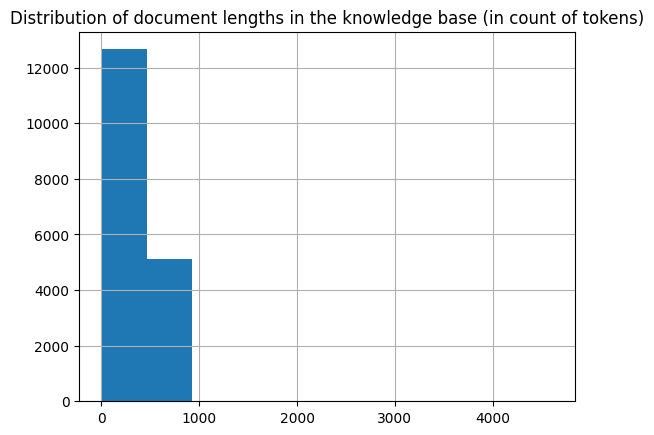

In [15]:
# Plot the distribution of document lengths, counted as the number of tokens
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(documents)]
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

In [ ]:
# Embed documents
vector_database = FAISS.from_documents(
    documents,
    embedding_model,
    distance_strategy=DistanceStrategy.COSINE
)

Error: mkl-service + Intel(R) MKL: MKL_THREADING_LAYER=INTEL is incompatible with libgomp.so.1 library.
	Try to import numpy first or set the threading layer accordingly. Set MKL_SERVICE_FORCE_INTEL to force it.


## Retriever

In [ ]:
user_query = "How to create a pipeline object?"
query_vector = embedding_model.embed_query(user_query)

In [ ]:
embedding_projector = pacmap.PaCMAP(n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0, random_state=1)

embeddings_2d = [
    list(vector_database.index.reconstruct_n(idx, 1)[0]) for idx in range(len(documents))
] + [query_vector]

# Fit the data (the index of transformed data corresponds to the index of the original data)
documents_projected = embedding_projector.fit_transform(np.array(embeddings_2d), init="pca")

In [ ]:
# Visualize the embedding
df = pd.DataFrame.from_dict(
    {
        "x": documents_projected[:, 0],
        "y": documents_projected[:, 1],
        "source": [doc.metadata["source"] for doc in documents] + ["User query"],
        "extract": [doc.page_content[:100] for doc in documents] + [user_query],
        "size_col": [len(doc.page_content) for doc in documents] + [len(user_query)],
        "symbol": ["Document" for _ in documents] + ["User query"],
    }
)
figure = px.scatter(
    df,
    x="x",
    y="y",
    color="source",
    hover_data="extract",
    size="size_col",
    symbol="symbol",
    color_discrete_map={"User query": "black"},
    width=1000,
    height=700,
)
figure.update_traces(
    marker=dict(opacity=1, line=dict(width=0, color="DarkSlateGrey")),
    selector=dict(mode="markers"),
)
figure.update_layout(
    legend_title_text="<b>Chunk source</b>",
    title="<b>2D Projection of Chunk Embeddings via PaCMAP</b>",
)
figure.show()

In [ ]:
print(f"\nStarting retrieval for {user_query=}...")
retrieved_docs = vector_database.similarity_search(query=user_query, k=5)
print("\n==================================Top document==================================")
print(retrieved_docs[0].page_content)
print("==================================Metadata==================================")
print(retrieved_docs[0].metadata)

## Reader

In [ ]:
def prompt_template(context, question):
    return (
        "<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\n"
        "You are Korean. Use Korean only. 한국어만 사용하세요.\n"
        "Answer the question based on your knowledge. Use the following context to help:\n"
        f"{context}<|eot_id|>"
        
        "<|start_header_id|>user<|end_header_id|>\n\n"
        f"{question}<|eot_id|>"
        
        "<|start_header_id|>assistant<|end_header_id|>\n\n"
    )

In [ ]:
retrieved_docs_text = [doc.page_content for doc in retrieved_docs]  # We only need the text of the documents
retrieved_docs = "\nExtracted documents:\n"
retrieved_docs += "".join([f"Document {str(i)}:::\n" + doc for i, doc in enumerate(retrieved_docs_text)])

In [ ]:
def generate_response(context, question):
    prompt = prompt_template(context, question)
    
    input_ids = tokenizer.encode(
        prompt,
        max_length=max_length,
        padding=padding,
        truncation=truncation,
        add_special_tokens=True,
        return_tensors="pt"
    ).to(device)
    
    outputs = model.generate(
        input_ids=input_ids,
        pad_token_id=tokenizer.eos_token_id,
        num_return_sequences=num_return_sequences,
        max_new_tokens=max_new_tokens,
        do_sample=do_sample,
        temperature=temperature,
        top_p=top_p,
        repetition_penalty=repetition_penalty,
        streamer=streamer
    )

    return tokenizer.decode(outputs[0], skip_special_tokens=False)

In [ ]:
user_prompt = "How to create a pipeline object?"

In [ ]:
response = generate_response(retrieved_docs, user_prompt)